# Make mock IFU datacubes for stellar population and kinematic modelling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import popkinmocks as pkm

## Get SSP templates and an IFU-cube

In [2]:
ssps = pkm.model_grids.milesSSPs()
ssps.logarithmically_resample(dv=50.)
ssps.calculate_fourier_transform()
ssps.get_light_weights()
cube = pkm.ifu_cube.IFUCube(ssps=ssps, nx=25, ny=25, xrng=(-1,1), yrng=(-1,1))

## Create a disk component

We can next create a galaxy component. Let's start with a disk,

In [3]:
disk1 = pkm.components.growingDisk(cube=cube, rotation=0., center=(0,0))

### Star formation history

Specify the star formation history of the disk as a beta distribution with mean `0<phi<1` and concentration `lmd`,

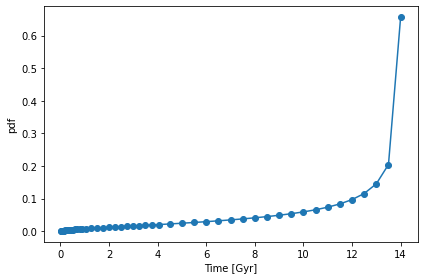

In [4]:
disk1.set_p_t(lmd=2., phi=0.8)
disk1.plot_sfh()

### Age-dependent spatial density

Set the age dependent spatial-density. These are cored power law profiles stratified on elliptical radii with axis ratio `q`. All parameters are specified as (end, start) values i.e. at the end (recent) and start (long ago) of disk growth. Beteen these times, parameters are linearly interpolated.

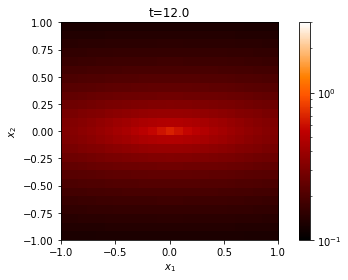

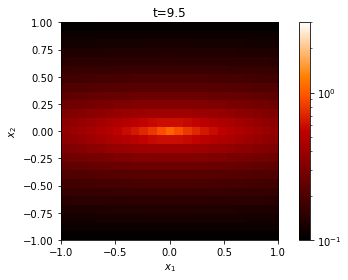

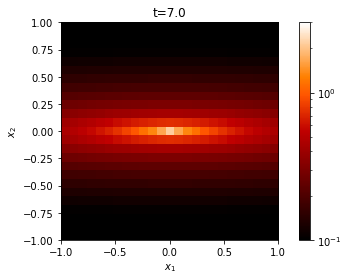

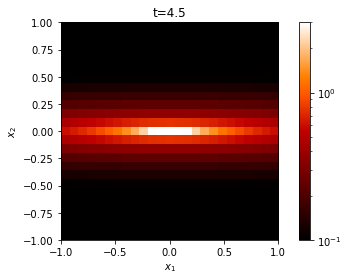

In [5]:
disk1.set_p_x_t(q_lims=(0.1, 0.3),
                rc_lims=(0.1, 0.9),
                alpha_lims=(1.2, 0.8))
disk1.plot_density(show_every_nth_time=5)

### Spatially-dependent chemical enrichment

These come from age-metallicity models written down in equations 3-10 of [Zhu et al 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.496.1579Z/abstract). The models are parameterised by depletion timescale `t_dep`. This parameter stratified on ellipses parameterised by axis ratio `q`, a power law slope `alpha` and an inner and outer values,

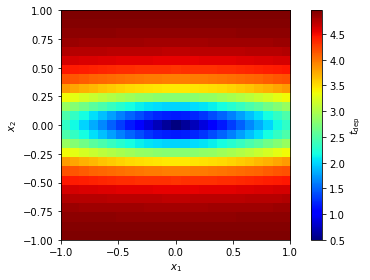

In [6]:
disk1.set_t_dep(q=0.2,
                alpha=3.,
                t_dep_in=0.5,
                t_dep_out=5.)
disk1.set_p_z_tx()
disk1.plot_t_dep()

### Age- and Space- depentdent kinemtaics

We spcify age-dependant maps of mean velocities and velocity dispersions. For an SSP of a single age, the LOSVD is Gaussian with this mean and dispersion. The combined LOSVD, for all ages, can be non-Gaussian.

The mean maps take the form of rotating disks. Specified by an axis ratio `q`, and the radius `rmax` and value `vmax` of the maximum velocity. Each parameter is a tuple of (end, start) values, which are linearly interpolated between

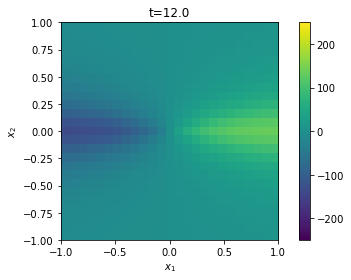

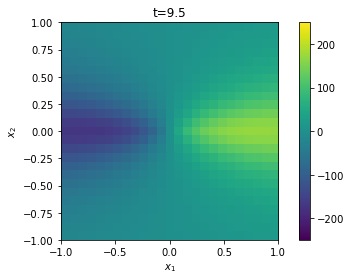

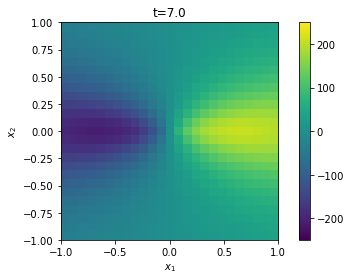

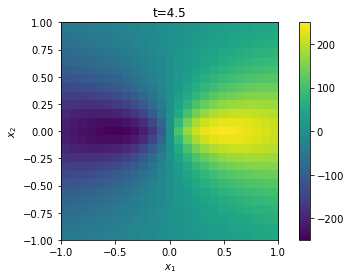

In [7]:
disk1.set_mu_v(q_lims=(0.5, 0.1),
               rmax_lims=(0.5, 1.1),
               vmax_lims=(250., 100.))
disk1.plot_mu_v(show_every_nth_time=5)

Dispersion maps are by power laws stratified on ellipses, parameterised with axis ratio `q`, power law slope `alpha` and inner and outer values,

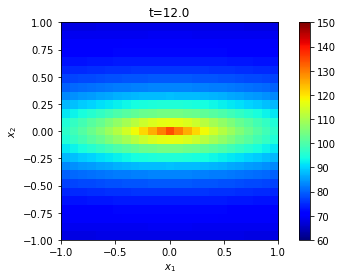

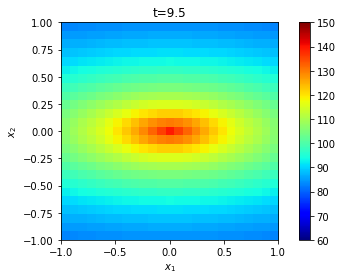

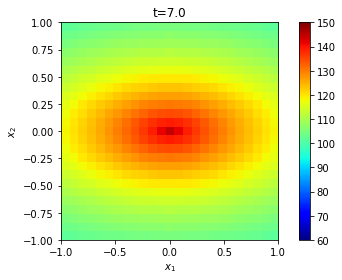

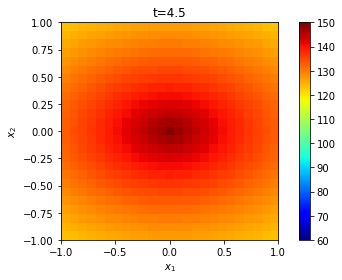

In [8]:
disk1.set_sig_v(q_lims=(0.7, 0.1), 
                alpha_lims=(1.2, 2.0),
                sig_v_in_lims=(150., 130.),
                sig_v_out_lims=(80., 60.))
disk1.plot_sig_v(show_every_nth_time=5)

### Evaluating densities

We can evaluate various densties of the for the disk component we have just defined. These are marginal and conditional desnities of the joint density $p(t,v,x,z)$. For example, if we want the spatially-dependent age and metallicity maps, $p(t,z|x)$, we can get this as follows:

In [9]:
p_tz_x = disk1.get_p_tz_x()

In [10]:
p_tz_x.shape

(53, 12, 25, 25)

These dimensions correspond to $(t,z,x_1,x_2)$ i.e. the order they appear in the name of the method `get_p_tz_x`. Let's plot the (t,z) distribution in a given pixel (i, j),

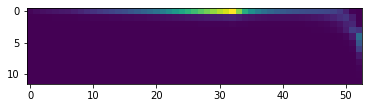

In [11]:
i, j = 12, 12

def orient_image(img):
    return np.flipud(img.T)

plt.imshow(orient_image(p_tz_x[:,:,i,j]))

By default, the methods to evaluate densities give densities without a volume-element factor. If instead we want weights with a volume-element factor, i.e. which sum to 1, we can specify this with `density=False`,

In [12]:
p_tz_x = disk1.get_p_tz_x(density=False)
print(np.sum(p_tz_x[:,:,i,j]))

0.9999999999999999


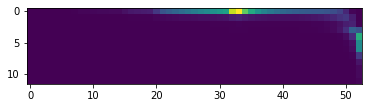

In [13]:
plt.imshow(orient_image(p_tz_x[:,:,i,j]))

Also by default, all distributions are mass-weighted. To get a light-weighted distribution we can add the `light_weighted=True` keyword,

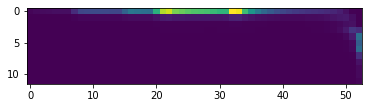

In [14]:
p_tz_x = disk1.get_p_tz_x(light_weighted=True, density=False)
plt.imshow(orient_image(p_tz_x[:,:,i,j]))

The full list of available methods to evaluate densities are `get_p_`+
- `t`
- `x_t`
- `tx`
- `z_tx`
- `txz`
- `x`
- `z`
- `tz_x`
- `tz`
- `v_tx`
- `tvxz`
- `v_x`
- `v`

These methods evaluate give the joint distribution of everything to the left of the underscore, conditioned on everthing to the right. These will return arrays where the dimensions correspond to the variables in the order they appear in the method name.

Lastly, we can evaluate the datacube contibution coming from this disk using the `evaluate_bar` method. At each position, each SSP is convolves with an age-dependent Gaussian LOSVD. These are combined according to the weights defined by the spatial density and chemical enrichments,

In [15]:
disk1.evaluate_ybar()
disk1.ybar.shape

(1944, 25, 25)

Dimensions correspond to wavelength and two spatial directions. Two plot the (noise-free) spectrum in a pixel $(i,j)$,

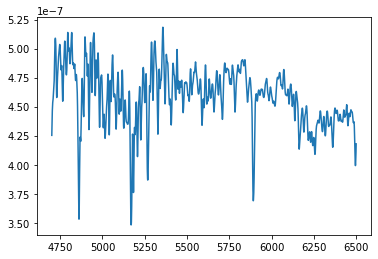

In [16]:
i,j = 12, 12
wavelength = np.exp(cube.ssps.w)
plt.plot(wavelength, disk1.ybar[:,i,j])

## Add a second disk

We can add a second compoent. We will make this younger, rounder, and counter-rotating to the first disk. (I wont show plots for `t_dep` and dispersion maps). 

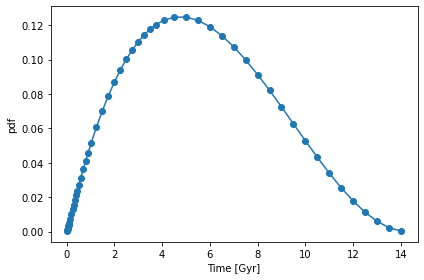

In [17]:
disk2 = pkm.components.growingDisk(cube=cube, rotation=0., center=(0,0))
disk2.set_p_t(lmd=5., phi=0.4)
disk2.plot_sfh()

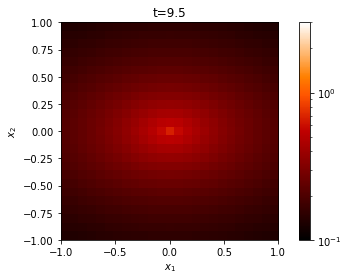

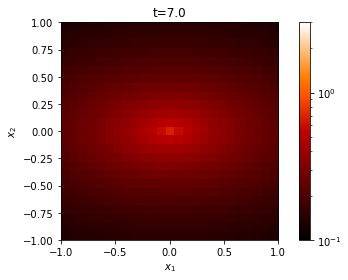

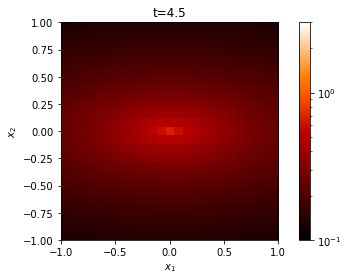

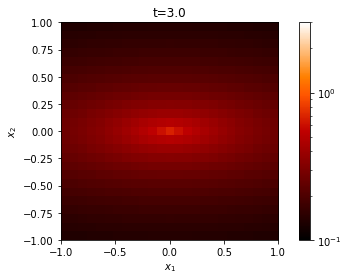

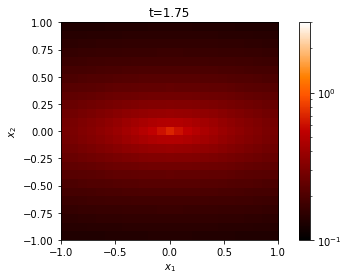

In [18]:
disk2.set_p_x_t(q_lims=(0.3, 0.7),
                rc_lims=(0.5, 0.6),
                alpha_lims=(0.8, 1.2))
disk2.plot_density(show_every_nth_time=5)

In [19]:
disk2.set_t_dep(q=0.4,
                alpha=2.,
                t_dep_in=2.,
                t_dep_out=9.)
disk2.set_p_z_tx()

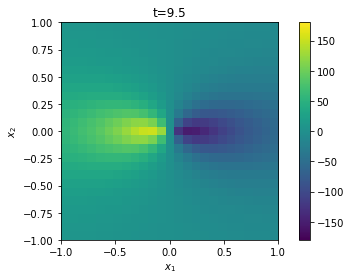

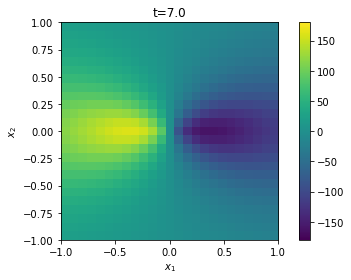

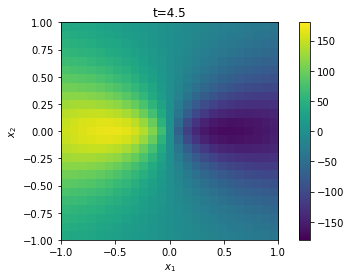

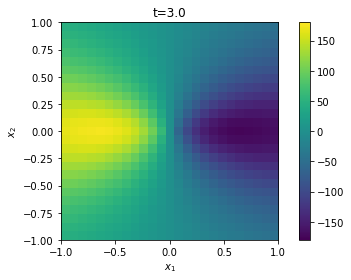

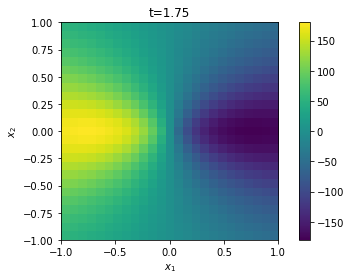

In [20]:
disk2.set_mu_v(q_lims=(0.5, 0.5),
               rmax_lims=(0.8, 0.1),
               vmax_lims=(-180., -150.))
disk2.plot_mu_v(show_every_nth_time=5)

In [21]:
disk2.set_sig_v(q_lims=(0.7, 0.5),
                alpha_lims=(1.6, 1.8),
                sig_v_in_lims=(40., 100.),
                sig_v_out_lims=(20., 70.))

In [22]:
disk2.evaluate_ybar()

## Combine the components

We can combine the two disks to create a mixture model for the galaxy. We need a list of components and their (sum to 1) weights,

In [23]:
cmp_list = [disk1, disk2]
w = [0.8, 0.2]
cube.combine_components(cmp_list, w)

Just as for the individual compoennts, we can extract densities for the galaxy mixture model. Say we want to evaluate the light-weighted spatially dependent LOSVDs. Need to define an array of velocity bin-edges,

In [24]:
vedg = np.linspace(-750, 750, 100)
p_v_x = cube.get_p('v_x', v_edg=vedg, light_weighted=True)
p_v_x.shape

(2, 99, 25, 25)

Now, the dimensions correspond to (i) the 2 disks, (ii) velcoity, (iii/iv) 2D spatial position. Let's plot the LOSVD at a position $(i,j)$,

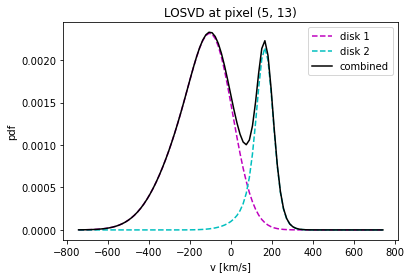

In [25]:
i, j = 5, 13

vcnt = (vedg[:-1]+vedg[1:])/2.
plt.plot(vcnt, p_v_x[0,:,i,j], '--m', label='disk 1')
plt.plot(vcnt, p_v_x[1,:,i,j], '--c', label='disk 2')
plt.plot(vcnt, np.sum(p_v_x[:,:,i,j], 0), '-k', label='combined')
plt.gca().set_title(f'LOSVD at pixel {i,j}')
plt.gca().set_xlabel('v [km/s]')
plt.gca().set_ylabel('pdf')
plt.gca().legend()